In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize': [14, 8]})
import plotly.express as px

import csv
from datetime import datetime
import pickle
from tqdm.auto import trange, tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torchmetrics.classification import MultilabelF1Score
from transformers import AutoTokenizer, AutoModel

In [2]:
categories = {
    1: 'Gun/2nd Amendment rights',
    2: 'Gun control/regulation',
    3: 'Politics',
    4: 'Mental health',
    5: 'School or public space safety',
    6: 'Race/ethnicity',
    7: 'Public opinion',
    8: 'Society/culture',
    9: 'Economic consequences',
    99: 'None of the above',
}

In [3]:
data = pd.read_csv('data/GVFC/GVFC_extension_multimodal.csv')
print(len(data))
data.head(2)

1300


,id,article_url,headline,google_visual_api_web_entities_detection_on_lead_image,automatically_generated_caption_of_lead_image,lead_3_sentences_summary_of_full_article_text,presum_summary_of_full_article_text,Q1 Relevant,Q2 Focus,Q3 Theme1,Q3 Theme2,V1image,V2ethnicity,V3relevance,V4relevance,Q4 Image1,Q4 Image2
0,0,http://beta.latimes.com/nation/la-na-paddock-c...,Cremated remains of Las Vegas mass shooter to ...,Stephen Paddock 2017 Las Vegas Strip shooting ...,"Eric Paddock, center, with his brother Eric Pa...","""Cremated remains of Las Vegas mass shooter to...","""cremated remains of las vegas mass shooter to...",1,2,7,99,1,0,0,99.0,6,99
1,1,https://www.yahoo.com/news/florida-shooter-tro...,Florida shooter a troubled loner with white su...,Nikolas Cruz Stoneman Douglas High School shoo...,"A photograph of the suspect, Nikolas Cruz.",Parkland (Etats-Unis) (AFP) - Nikolas Cruz was...,nikolas cruz was expelled from school after be...,1,1,4,6,1,0,1,0.0,7,0


In [4]:
print(data.iloc[0].headline, '\n')
print(data.iloc[0].google_visual_api_web_entities_detection_on_lead_image, '\n')
print(data.iloc[0].automatically_generated_caption_of_lead_image, '\n')
print(data.iloc[0].lead_3_sentences_summary_of_full_article_text, '\n')
print(data.iloc[0].presum_summary_of_full_article_text)

Cremated remains of Las Vegas mass shooter to be kept in safe deposit box, brother says 

Stephen Paddock 2017 Las Vegas Strip shooting Shooting Motive Mass shooting McCarran International Airport Firearm Eric Paddock Massacre Las Vegas Metropolitan Police Department 

Eric Paddock, center, with his brother Eric Paddock, right, and his brother Eric Paddock in October 2017. 

"Cremated remains of Las Vegas mass shooter to be kept in safe deposit box, brother says By David Montero Jan 18, 2018 | 2:20 PM | Las Vegas Eric Paddock in October 2017 holds a photo of himself, at left, and his brother, Las Vegas gunman Stephen Paddock. (John Raoux / Associated Press) 

"cremated remains of las vegas mass shooter to be kept in safe deposit box, " coroner says. stephen paddock, 64, was shot dead in his home in orlando, florida, on oct. 1. " i'm not going to do something stupid, " attorney says. " we're going to make sure there's no hoopla around steve's " in a bank deposit box


In [5]:
columns = ['headline', 'Q3 Theme1', 'Q3 Theme2']
data = data[columns].rename(columns={'Q3 Theme1': 'Theme1', 'Q3 Theme2': 'Theme2'})
data.head(3)

,headline,Theme1,Theme2
0,Cremated remains of Las Vegas mass shooter to ...,7,99
1,Florida shooter a troubled loner with white su...,4,6
2,Vernon Hills teen accused of wearing white sup...,6,99


In [6]:
count1 = data[['Theme1', 'headline']].groupby('Theme1').count().reset_index().rename(columns={'Theme1': 'Theme', 'headline': 'Count1'})
count2 = data[['Theme2', 'headline']].groupby('Theme2').count().reset_index().rename(columns={'Theme2': 'Theme', 'headline': 'Count2'})
counts = count1.merge(count2, how='outer')
counts['Names'] = categories.values()

<AxesSubplot: xlabel='Count1', ylabel='Names'>

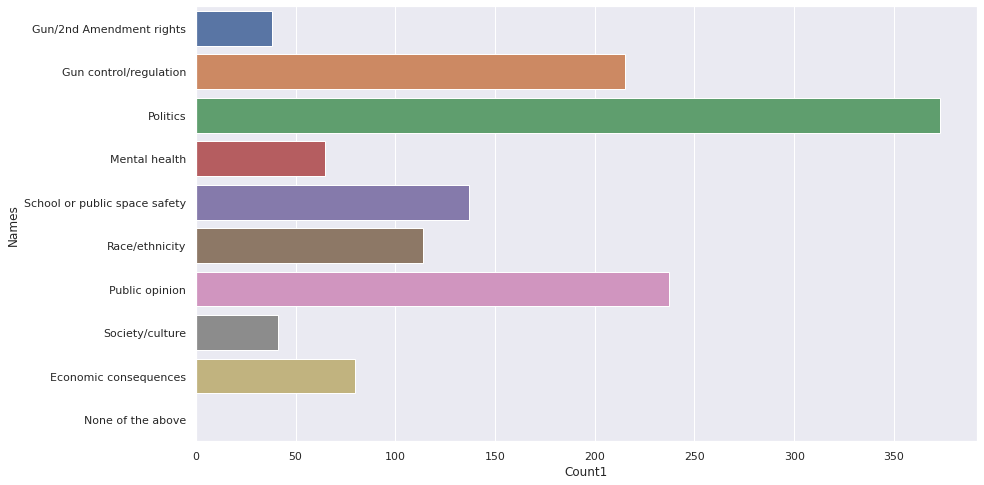

In [7]:
sns.barplot(counts, y='Names', x='Count1', orient='h', )

<AxesSubplot: xlabel='Count2', ylabel='Names'>

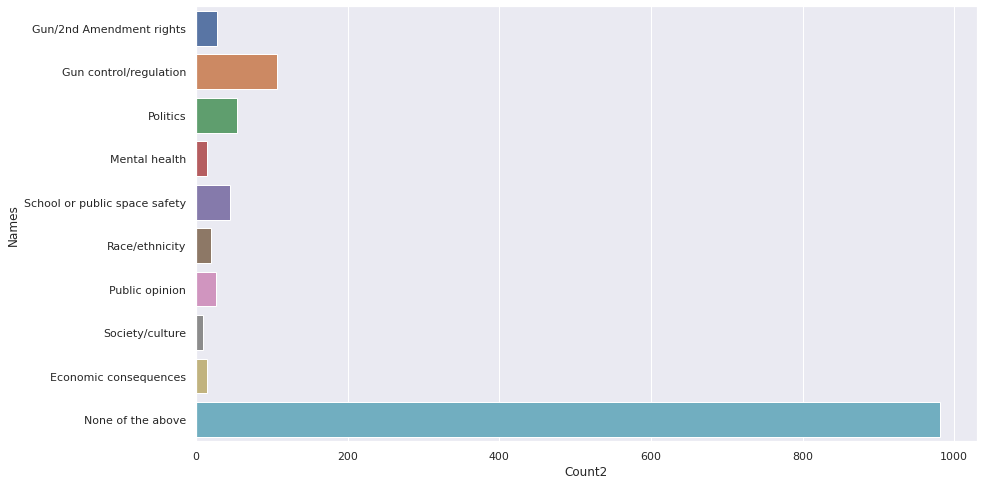

In [8]:
sns.barplot(counts, y='Names', x='Count2', orient='h', )

Text(0.5, 1.0, 'Headline Word Count')

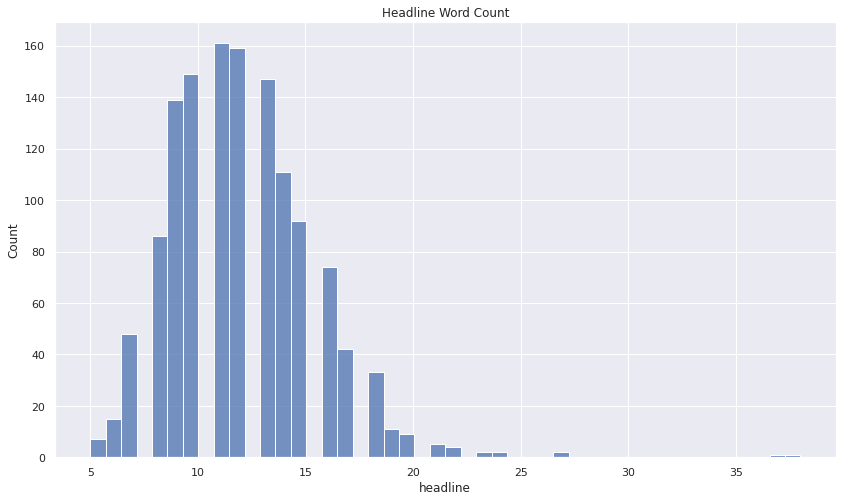

In [9]:
sns.histplot(data.headline.str.split(' ').apply(len)).set_title('Headline Word Count')

Text(0.5, 1.0, 'Headline Character Count')

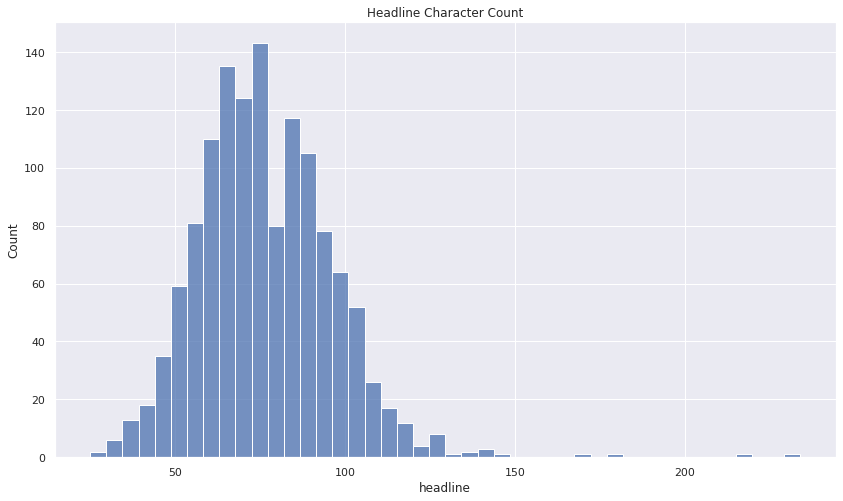

In [10]:
sns.histplot(data.headline.str.len()).set_title('Headline Character Count')

# Liu Baseline

BERT 5-fold cross validation micro baseline: 84.23%

# TfIdf Baseline

In [11]:
N_SPLITS=5

In [12]:
use_dataset = data
kf = KFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
microf1s = []
macrof1s = []
for train_idx, test_idx in tqdm(kf.split(use_dataset)):
    train_dataset, eval_dataset = use_dataset.iloc[train_idx], use_dataset.iloc[test_idx]
    
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('svc', OneVsRestClassifier(SVC()))
    ])
    pipeline.fit(train_dataset.headline, train_dataset.Theme1)
    predictions = pipeline.predict(eval_dataset.headline)

    microf1s.append(f1_score(predictions, eval_dataset.Theme1, average='micro'))
    macrof1s.append(f1_score(predictions, eval_dataset.Theme1, average='macro'))

0it [00:00, ?it/s]

In [13]:
print(np.mean(microf1s))
print(np.mean(macrof1s))

0.6715384615384614
0.5313901664487249


# Untrained Embeddings Baseline

In [15]:
with open('embeddings/GVFC_mpnet_embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)
embeddings.shape

(1300, 768)

In [16]:
onehot = OneHotEncoder(sparse=False)
dataset = TensorDataset(
    torch.tensor(embeddings),
    torch.tensor(onehot.fit_transform(np.array(data.Theme1).reshape(-1, 1)), dtype=torch.float32),
)

In [17]:
criterion = nn.BCEWithLogitsLoss()
N_CLASSES = dataset[0][1].shape[0]
N_EPOCHS=60
BATCH_SIZE=50
GAMMA=1.
LR=1e-3
EMBEDDING_LEN = dataset[0][0].shape[0]

In [18]:
use_dataset = dataset
kf = KFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
metrics = list()
for train_idx, test_idx in kf.split(use_dataset):
    train_dataset, eval_dataset = TensorDataset(*use_dataset[train_idx]), TensorDataset(*use_dataset[test_idx])
    train_sampler = RandomSampler(train_dataset)
    train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
    eval_loader = DataLoader(eval_dataset)
    microf1_metric = MultilabelF1Score(num_labels=N_CLASSES, average='micro')
    macrof1_metric = MultilabelF1Score(num_labels=N_CLASSES, average='macro')
        
    head = nn.Sequential(
        nn.Linear(EMBEDDING_LEN, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, N_CLASSES),
        nn.Dropout(),
    )
    optimizer = torch.optim.AdamW(head.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

    losses, microf1s, macrof1s = [], [], []
    for epoch in trange(N_EPOCHS):
        head.train()
        torch.set_grad_enabled(True)
        epoch_losses = []
        for batch in train_loader:
            embeddings, labels = batch
            prediction_probs = head(embeddings)
            loss = criterion(prediction_probs, labels)
            epoch_losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()
        losses.append(np.mean(epoch_losses))
        
        head.eval()
        torch.set_grad_enabled(False)
        preds = list()
        labels = list()
        for batch in eval_loader:
            embeddings, ls = batch
            preds.append(torch.sigmoid(head(embeddings)))
            labels.append(ls)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        
        microf1s.append(microf1_metric(preds, labels).numpy())
        macrof1s.append(macrof1_metric(preds, labels).numpy())
    metrics.append((losses, microf1s, macrof1s))

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [19]:
def plot_torch_metrics(losses, microf1, macrof1):
    fig, ax = plt.subplots()
    loss = ax.plot(losses, label='Loss')
    ax2 = ax.twinx()
    m1 = ax2.plot(microf1, c='red', label='MicroF1')
    m2 = ax2.plot(macrof1, c='orange', label='MacroF1')
    ax2.axhline(np.max(microf1), c='red', linestyle='dashed')
    ax2.axhline(np.max(macrof1), c='orange', linestyle='dashed')
    lns = loss+m1+m2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs)
    plt.show()
    argmax_microf1 = np.argmax(microf1)
    print("MicroF1: ", microf1[argmax_microf1], " @ ", argmax_microf1)
    print("MacroF1: ", np.max(macrof1), " @ ", np.argmax(macrof1))
    print("MacroF1: ", macrof1[argmax_microf1], " @ ", argmax_microf1)

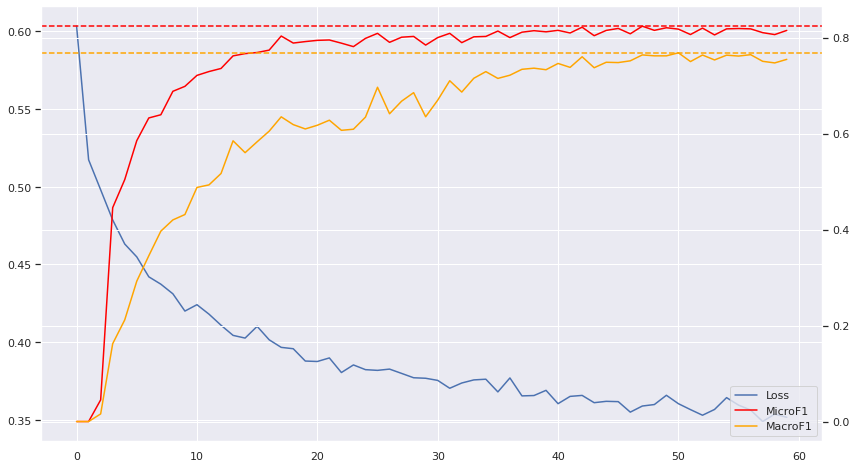

MicroF1:  0.82376236  @  47
MacroF1:  0.76825774  @  50
MacroF1:  0.7639021  @  47


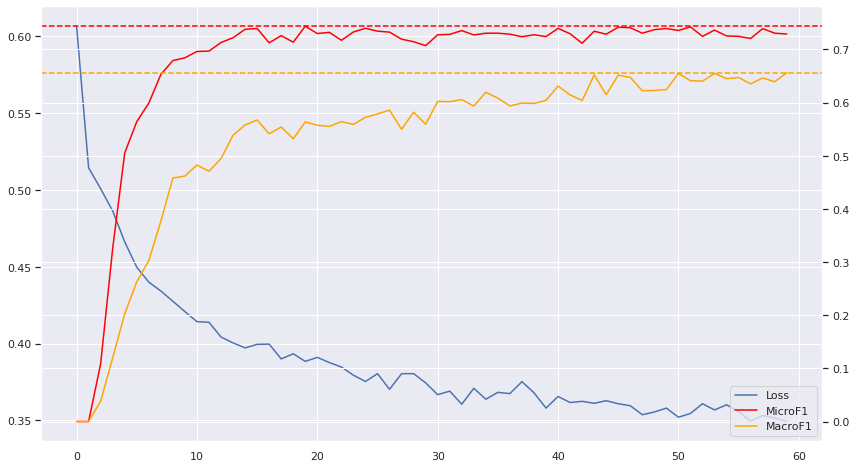

MicroF1:  0.74380165  @  19
MacroF1:  0.65635145  @  59
MacroF1:  0.56371903  @  19


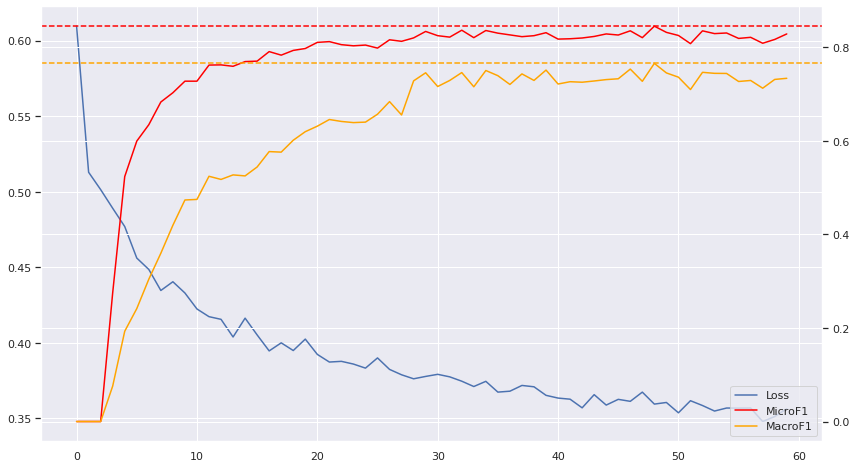

MicroF1:  0.8452381  @  48
MacroF1:  0.7656983  @  48
MacroF1:  0.7656983  @  48


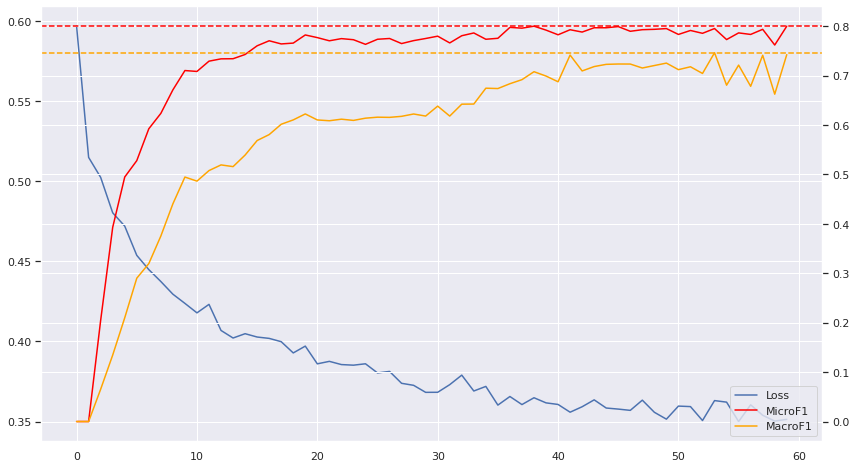

MicroF1:  0.8  @  38
MacroF1:  0.7463044  @  53
MacroF1:  0.70789844  @  38


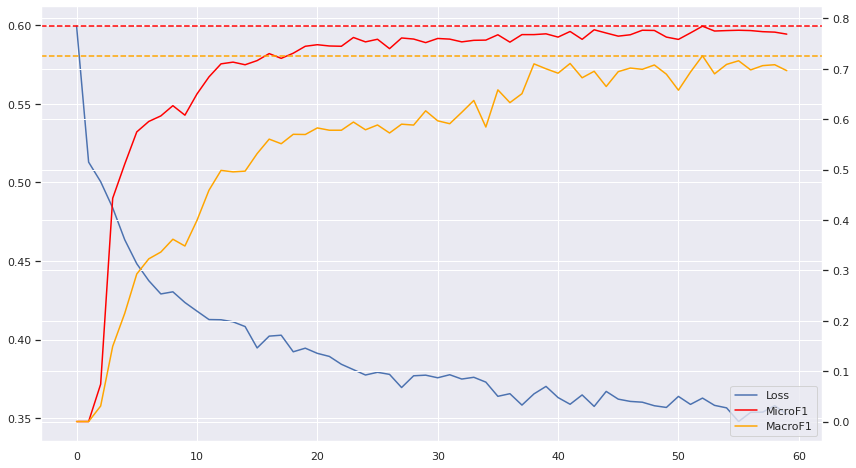

MicroF1:  0.78470826  @  52
MacroF1:  0.7259276  @  52
MacroF1:  0.7259276  @  52


In [20]:
for m in metrics:
    plot_torch_metrics(*m)

In [21]:
print(f"Average MicroF1: {np.mean([m[1][-1] for m in metrics])}")

Average MicroF1: 0.7883388996124268
